# PHYS3070: Couette Flow

In fluid dynamics, Couette flow is the flow of a
viscous fluid in the space between two surfaces, one of which is moving
tangentially relative to the other. The configuration often takes the form of
two parallel plates or the gap between two concentric cylinders. The flow is
driven by virtue of viscous drag force acting on the fluid, but may additionally
be motivated by an applied pressure gradient in the flow direction. The Couette
configuration models is often use to measure the viscosity of a fluid.

This notebook explain how to introduce non-linear viscosity (Stress / Pressure dependent)

<img src="images/1920px-Laminar_shear.png" width="800">

(source:Wikipedia)

## Import UWGeodynamics

We will use *UWGeodynamics*, a high-level interface to
the Underworld API.
The python module can be imported as follow.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /home/jovyan/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


## Scaling

In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 1.0 * u.meter / u.hour
model_length = 2. * u.meter
model_height = 1. * u.meter
refViscosity = 1e6 * u.pascal * u.second
bodyforce = 200 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
temperature_diff = 300. * u.degK

characteristic_length = model_height
characteristic_time = characteristic_length / velocity
characteristic_mass = bodyforce * characteristic_length**2 * characteristic_time**2
characteristic_temperature = temperature_diff

GEO.scaling_coefficients["[length]"] = characteristic_length
GEO.scaling_coefficients["[time]"] = characteristic_time
GEO.scaling_coefficients["[mass]"]=characteristic_mass
GEO.scaling_coefficients["[temperature]"] = characteristic_temperature

# Geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)

We define a tank in 2-dimensions. The dimension of the tank is set to be 1m in height and 1m in width. The extent of the tank is defined using the `minCoord` and `maxCoord` arguments chosen in a way that the origin is located at the center of the tank.

In [4]:
Model = GEO.Model(elementRes=(128, 64), 
                  minCoord=(-1.0 * u.m, 0. * u.m), 
                  maxCoord=(1.0 * u.m, 1.0 * u.m),
                  gravity=(0., -9.81 * u.m / u.s**2), 
                  periodic=(True, False))

In [5]:
Model.diffusivity = 1e-6 * u.meter**2 / u.second 

## Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
*UWGeodynamics* is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

The tank is filled with a viscous fluid (`background_fluid`).

In [6]:
background_fluid = Model.add_material(name="Background", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))

### Material properties

In [7]:
n = stressExponent = 2.0
reference_viscosity = (1e3 * u.pascal * u.second)**-(n - 1)

In [8]:
background_fluid.viscosity = GEO.ViscousCreep(preExponentialFactor=reference_viscosity, stressExponent=2.0)

## Define Boundary Conditions

The boundary conditions are freeslip everywhere (zero shear stress).

In [9]:
Model.set_velocityBCs(top=[1.0 * u.m / u.hour, 0.], bottom=[0., 0.], left=[None, 0.], right=[None, 0.])

### Visualisation of the Initial Velocity field


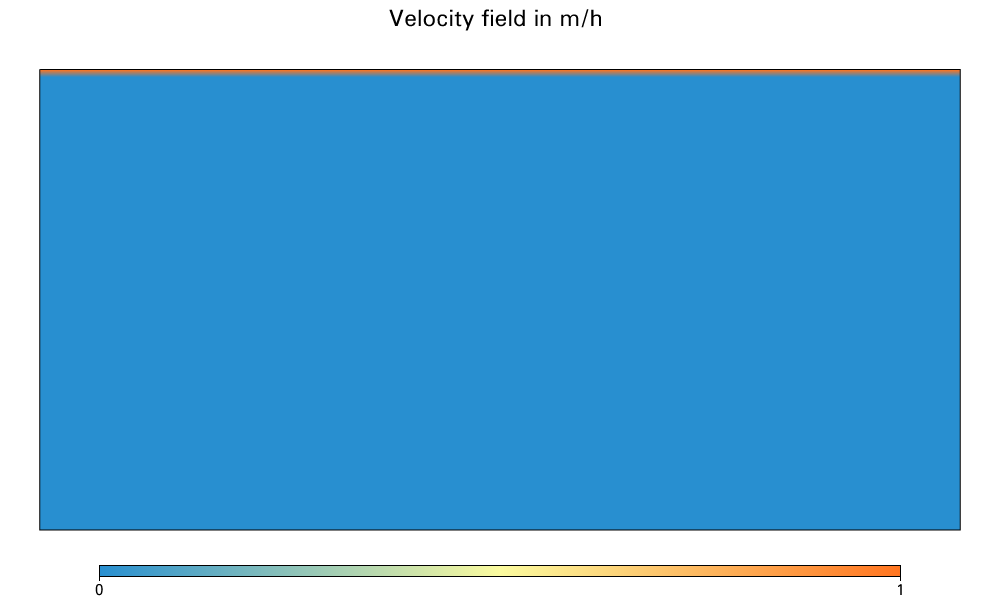

In [10]:
import underworld.function as fn

# Calculate the velocity magnitude
velocityMag = fn.math.dot(Model.velocityField, Model.velocityField)
# Get a conversion factor to units of m/hr
fact = GEO.dimensionalise(1.0, u.metre / u.hour).magnitude
# Apply the factor to the velocity Magnitude
velocityMag *= fact

Fig = vis.Figure(figsize=(1000,600), title="Velocity field in m/h")
Fig.Surface(Model.mesh, velocityMag)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

## Init and Run Model

In [11]:
Model.init_model()

In [12]:
Model.run_for(nstep=2)

Running with UWGeodynamics version 2.10.0-dev-b0ccd70(new_examples)
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
Step:     1 Model Time: 28.1 second dt: 28.1 second (2020-06-23 03:39:49)
Step:     2 Model Time: 0.9 minute dt: 28.1 second (2020-06-23 03:39:58)


1


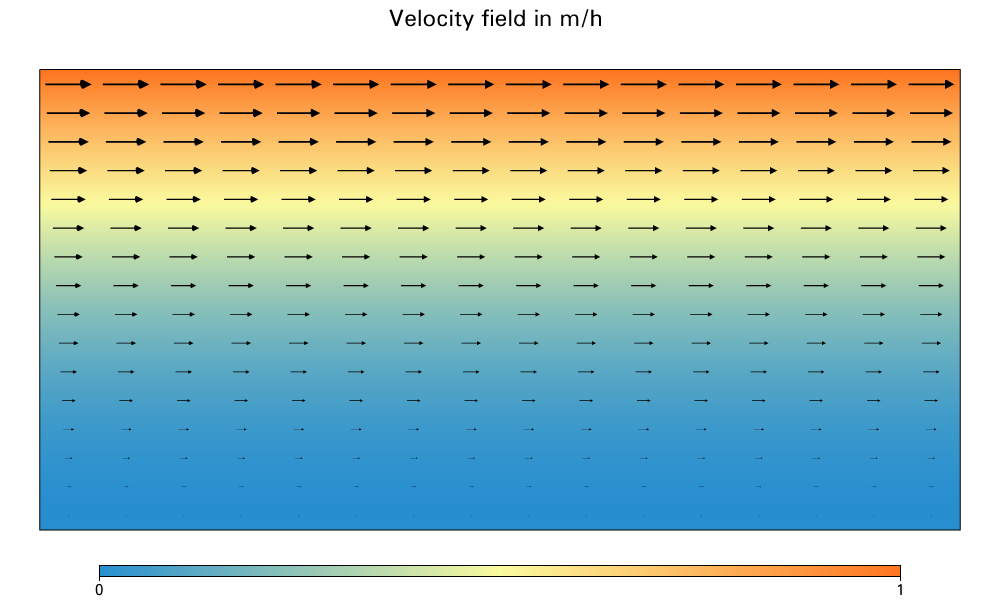

In [14]:
Fig = vis.Figure(figsize=(1000,600), title="Velocity field in m/h")
Fig.Surface(Model.mesh, velocityMag)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


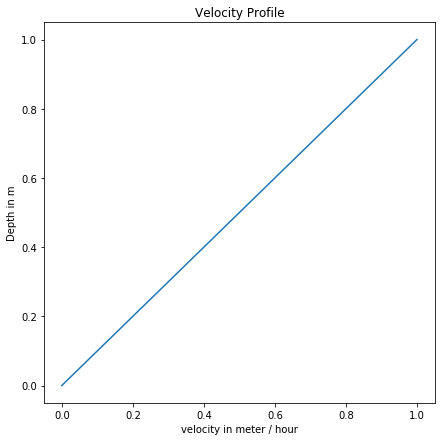

In [15]:
import matplotlib.pyplot as plt


if GEO.nProcs == 1:

    distances, vx = GEO.extract_profile(Model.velocityField[0], 
                                        line = [(-1.0 * u.m, Model.bottom), (-1.0 * u.m, Model.top)])

    Fig, (ax1) = plt.subplots(1,1,figsize=(7,7))
    ax1.plot(GEO.dimensionalise(vx, u.meter / u.hour), GEO.dimensionalise(distances, u.m))
    ax1.set_ylabel("Depth in m")
    ax1.set_xlabel("velocity in meter / hour")
    ax1.set_title("Velocity Profile")
    
plt.show()